<a href="https://colab.research.google.com/github/gustavovazquez/ML/blob/main/ML_Regularizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Regularización en Aprendizaje Automático  

- Entender por qué la regresión lineal clásica (OLS) a veces falla.
- Ver cómo la regularización **L2 (Ridge / Tikhonov)** arregla problemas de mala condición y no unicidad.
- Entender cómo **L1 (LASSO)** induce *sparsity* (coeficientes exactamente cero) y sirve para selección de variables.
- Comprender el papel del hiperparámetro $$\lambda$$ en el **tradeoff sesgo–varianza**.
- Conectar estas ideas con **redes neuronales** (weight decay, dropout, normalización, early stopping).
- Ver ejemplos concretos en Python que ilustren cada idea.




## 1. Motivación: ¿por qué necesitamos regularización?

El artículo comienza recordando algo muy clásico: la regresión lineal ajusta una recta (o hiperplano) a un conjunto de puntos, minimizando la **distancia** entre la recta estimada y los puntos observados.

En la regresión lineal simple, buscamos una recta de la forma

$$
\hat{y} = \beta_0 + \beta_1 x
$$

que se aproxime bien a los datos. En regresión lineal múltiple, generalizamos a

$$
\hat{y} = X \beta,
$$

donde:

- $X \in \mathbb{R}^{n \times p}$ es la matriz de diseño (cada fila es un ejemplo, cada columna es un *feature*).
- $\beta \in \mathbb{R}^p$ es el vector de coeficientes.
- $y \in \mathbb{R}^n$ es el vector de respuestas.

La regresión OLS (Ordinary Least Squares) busca los coeficientes que minimizan la suma de cuadrados de los residuos:

$$
\min_{\beta} \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \min_{\beta} \lVert y - X \beta \rVert_2^2.
$$

**Problema:** en la práctica, esta solución puede ser:

- **numéricamente inestable** (depende muchísimo de pequeñas variaciones en los datos),  
- o incluso **no única**, si hay multicolinealidad fuerte o sistemas sobredeterminados/subdeterminados.

Ahí entra la regularización.

A continuación recordamos la formulación matricial de OLS para entender dóndepuede incorporarse la regularización.



## 2. Recordatorio: regresión lineal y OLS en notación matricial

Partimos del modelo lineal:

$$
y = X \beta + \varepsilon,
$$

donde:
- $y \in \mathbb{R}^n$,
- $X \in \mathbb{R}^{n \times p}$,
- $\beta \in \mathbb{R}^p$,
- $\varepsilon$ es el término de error (ruido).

La función de pérdida de **mínimos cuadrados ordinarios (OLS)** es:

$$
J(\beta) = \lVert y - X\beta \rVert_2^2 = (y - X\beta)^{\top}(y - X\beta).
$$

El problema de optimización es:

$$
\hat{\beta}_{\text{OLS}} = \arg\min_{\beta} J(\beta).
$$

Vamos a derivar esta expresión y ver la forma cerrada de la solución.


In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Pequeño ejemplo sintético 1D para ilustrar OLS
rng = np.random.default_rng(0)
n = 50
X = rng.uniform(-3, 3, size=(n, 1))
beta_true = np.array([2.0])
y = X @ beta_true + rng.normal(scale=1.0, size=n)

ols = LinearRegression(fit_intercept=False)
ols.fit(X, y)

print("Coeficiente verdadero:", beta_true[0])
print("Coeficiente OLS estimado:", ols.coef_[0])

Coeficiente verdadero: 2.0
Coeficiente OLS estimado: 2.088226939598313



## 3. Derivando la función de pérdida de OLS

Partimos de

$$
J(\beta) = (y - X\beta)^{\top}(y - X\beta).
$$

La derivada (gradiente) respecto de $\beta$ es:

$$
\nabla_{\beta} J(\beta) = -2 X^{\top} (y - X\beta).
$$

(esto se puede ver expandiendo el producto y usando reglas básicas de cálculo matricial).

El mínimo se obtiene igualando el gradiente a cero:

$$
-2 X^{\top} (y - X\beta) = 0
\quad \Longrightarrow \quad
X^{\top} X \, \hat{\beta}_{\text{OLS}} = X^{\top} y.
$$

Estas son las **ecuaciones normales**.

Si la matriz $$X^{\top} X$$ es invertible, podemos escribir la solución cerrada como:

$$
\hat{\beta}_{\text{OLS}} = (X^{\top} X)^{-1} X^{\top} y.
$$

Esta solución puede ser problemática cuando $X^{\top} X$ está mal condicionada.



## 4. Condición de invertibilidad y problemas de OLS

La fórmula

$$
\hat{\beta}_{\text{OLS}} = (X^{\top} X)^{-1} X^{\top} y
$$

**solo tiene sentido** si $X^{\top} X$ es invertible.

Eso implica:

- Las columnas de $X$ deben ser **linealmente independientes**.
- No podemos tener columnas redundantes (o casi redundantes) → **multicolinealidad** fuerte.

En la práctica pueden suceder varias cosas:

- $X^{\top} X$ es **casi singular** → el número de condición es muy grande, y la solución es muy sensible a pequeñas perturbaciones en $X$ o $y$.
- Hay demasiados *features* (p grande) en relación a n → sistema subdeterminado.
- datos muy redundantes → no unicidad en la solución.

En estos casos, **no hay una solución única o estable** para OLS. Veamos un ejemplo con multicolinealidad.


In [2]:
from numpy.linalg import cond

rng = np.random.default_rng(1)
n = 200

x1 = rng.normal(size=n)
# x2 casi igual a x1 -> fuerte multicolinealidad
x2 = x1 + rng.normal(scale=0.01, size=n)

X_mc = np.column_stack([x1, x2])
beta_true_mc = np.array([3.0, -2.0])
y_mc = X_mc @ beta_true_mc + rng.normal(scale=0.5, size=n)

XtX = X_mc.T @ X_mc
print("Número de condición de X^T X:", cond(XtX))

ols_mc = LinearRegression(fit_intercept=False)
ols_mc.fit(X_mc, y_mc)
print("Coeficientes verdaderos:", beta_true_mc)
print("Coeficientes OLS estimados:", ols_mc.coef_)

Número de condición de X^T X: 42623.9886992594
Coeficientes verdaderos: [ 3. -2.]
Coeficientes OLS estimados: [ 14.52703871 -13.46969812]



## 5. De OLS a regularización: idea general

> ¿Cómo se relaciona OLS con la idea de regularización, y por qué añadimos un término extra a la función de pérdida *loss*?

La idea es **introducir restricciones adicionales** sobre los coeficientes $\beta$ para:

- evitar soluciones con coeficientes enormes,
- hacer el problema mejor condicionado,
- y (en algunos casos) obtener una solución única cuando antes no la había.

Formalmente, podemos pasar de:

$$
\min_{\beta} \lVert y - X\beta \rVert_2^2
$$

a algo del estilo:

$$
\min_{\beta} \lVert y - X\beta \rVert_2^2
\quad \text{sujeto a} \quad
\lVert \beta \rVert \le c.
$$

Usando multiplicadores de Lagrange, esto equivale a añadir un **término de penalización** a la función de pérdida *loss*:

$$
\mathcal{L}(\beta, \lambda)
= \lVert y - X\beta \rVert_2^2
+ \lambda \,\text{penalización}(\beta),
$$

donde $\lambda \ge 0$ controla la fuerza de la penalización.

La forma más típica de penalización es la norma L2 de $\beta$ → **Ridge / Tikhonov**.



## 6. Tikhonov / Ridge: definición de la penalización L2

La primera forma de regularización discutida es **L2 (Ridge / Tikhonov)**.

La función de pérdida pasa de ser solo OLS a:

$$
J_{\text{ridge}}(\beta)
= \lVert y - X\beta \rVert_2^2
+ \lambda \sum_{j=1}^{p} \beta_j^2
= \lVert y - X\beta \rVert_2^2 + \lambda \lVert \beta \rVert_2^2.
$$

Interpretaciones:

- Como problema restringido (con Lagrange):
  $$
  \lVert y - X\beta \rVert_2^2
  \quad \text{sujeto a} \quad
  \sum_{j=1}^p \beta_j^2 \le c.
  $$
- Como penalización:
  el término $\lambda \lVert \beta \rVert_2^2$ **penaliza coeficientes grandes**.

Intuición:
- Si muchos $\beta_j$ son grandes, la suma de cuadrados crece, lo que aumenta el *loss*.
- El modelo prefiere soluciones donde los coeficientes sean **más pequeños** (aunque no necesariamente cero).

Veamos cómo cambia la solución al pasar de OLS a Ridge en el caso con multicolinealidad.


In [3]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0, fit_intercept=False)  # alpha = λ
ridge.fit(X_mc, y_mc)
print("Coeficientes OLS:", ols_mc.coef_)
print("Coeficientes Ridge (λ=1.0):", ridge.coef_)

Coeficientes OLS: [ 14.52703871 -13.46969812]
Coeficientes Ridge (λ=1.0): [0.63554545 0.41154086]



## 7. Interpretación con multiplicadores de Lagrange (Tikhonov)

Conexión con la formulación de **Tikhonov** y los multiplicadores de Lagrange.

Partimos de un problema restringido:

$$
\min_{\beta} \lVert y - X\beta \rVert_2^2
\quad \text{sujeto a} \quad
\sum_{j=1}^p \beta_j^2 = c.
$$

El Lagrangiano asociado es:

$$
\mathcal{L}(\beta, \lambda)
= \lVert y - X\beta \rVert_2^2 +
\lambda \left( \sum_{j=1}^p \beta_j^2 - c \right).
$$

Al derivar respecto de $\beta$, el término con $c$ desaparece (es constante) y aparece una contribución de la forma $2 \lambda \beta$. Eso es lo que lleva a la aparición de un término $\lambda I$ en las ecuaciones normales.

Lo importante aquí es la interpretación conceptual:

- Añadimos una **restricción sobre el tamaño** de los coeficientes.
- Esto convierte un problema posiblemente mal condicionado en uno **bien condicionado**.



## 8. Derivación de la solución de Ridge

Volvamos a la función de pérdida con regularización L2:

$$
J_{\text{ridge}}(\beta)
= (y - X\beta)^{\top}(y - X\beta) + \lambda \beta^{\top} \beta.
$$

Calculamos el gradiente:

$$
\nabla_{\beta} J_{\text{ridge}}(\beta)
= -2 X^{\top}(y - X\beta) + 2 \lambda \beta.
$$

Igualamos a cero para encontrar el mínimo:

$$
-2 X^{\top}(y - X\beta) + 2 \lambda \beta = 0
$$

$$
\Longrightarrow \quad
X^{\top} X \beta + \lambda \beta = X^{\top} y
$$

$$
\Longrightarrow \quad
(X^{\top} X + \lambda I) \hat{\beta}_{\text{ridge}} = X^{\top} y.
$$

Por tanto, la solución cerrada de Ridge es:

$$
\hat{\beta}_{\text{ridge}}
= (X^{\top} X + \lambda I)^{-1} X^{\top} y.
$$

Observa la diferencia clave con OLS: el término extra $\lambda I$.


In [4]:
from numpy.linalg import cond

XtX = X_mc.T @ X_mc
lambdas = [0.0, 0.01, 0.1, 1.0, 10.0]

for lam in lambdas:
    M = XtX + lam * np.eye(XtX.shape[0])
    print(f"λ={lam:>4}, número de condición(X^T X + λI) = {cond(M):8.2e}")

λ= 0.0, número de condición(X^T X + λI) = 4.26e+04
λ=0.01, número de condición(X^T X + λI) = 1.90e+04
λ= 0.1, número de condición(X^T X + λI) = 3.19e+03
λ= 1.0, número de condición(X^T X + λI) = 3.42e+02
λ=10.0, número de condición(X^T X + λI) = 3.54e+01



## 9. Efecto de L2 sobre el condicionamiento numérico

La matriz $X^{\top} X$ puede tener autovalores muy pequeños (casi 0) cuando hay multicolinealidad.

Al sumar $\lambda I$:

- Cada autovalor $\mu_i$ de $X^{\top} X$ se transforma en $\mu_i + \lambda$.
- Eso **aleja todos los autovalores de 0**, haciendo la matriz más fácil de invertir.
- El **número de condición** disminuye mucho.

**La regularización L2 no solo “reduce overfitting”, sino que mejora el problema numérico de invertir una matriz mal condicionada.**

El código anterior muestra cómo cambia el número de condición de $X^{\top} X + \lambda I$ al variar $\lambda$.



## 10. L1 / LASSO: definición y comparación con L2

El artículo pasa luego a **L1 regularization**, conocida en regresión como **LASSO**.

La función de pérdida se modifica así:

$$
J_{\text{lasso}}(\beta)
= \lVert y - X\beta \rVert_2^2
+ \lambda \sum_{j=1}^p |\beta_j|
= \lVert y - X\beta \rVert_2^2 + \lambda \lVert \beta \rVert_1.
$$

Diferencias respecto de L2:

- En L2, la penalización es $$\sum \beta_j^2$$ (siempre positiva, suave).
- En L1, la penalización es $$\sum |\beta_j|$$ (tiene una “punta” en 0 → no diferenciable).

Similitudes:

- Ambas añaden un término controlado por $\lambda$.
- Ambas buscan evitar coeficientes muy grandes.

Pero L1 tiene una propiedad extra:  
tiende a producir coeficientes **exactamente cero** → *sparsity*.


In [5]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, fit_intercept=False, max_iter=10000)
lasso.fit(X_mc, y_mc)
print("Coeficientes OLS:", ols_mc.coef_)
print("Coeficientes LASSO (λ=0.1):", lasso.coef_)

Coeficientes OLS: [ 14.52703871 -13.46969812]
Coeficientes LASSO (λ=0.1): [0.9347085 0.       ]



## 11. Casos en la derivada de LASSO (betas > 0, < 0, = 0)

Cómo luce la derivada (en realidad, el **subgradiente**) del término L1.

En una dimensión, la función $$|\beta|$$ tiene derivada:

- Si $\beta > 0$, la derivada es $+1$.
- Si $\beta < 0$, la derivada es $-1$.
- Si $\beta = 0$, la derivada no está definida de forma única, pero el **subgradiente** es cualquier valor en el intervalo $[-1, 1]$.

En forma verbal: en 0 hay una “punta” (kink).

Cuando derivamos el *loss* de LASSO con respecto a cada $\beta_j$, aparecen estos casos, y eso permite que la solución óptima ocurra exactamente en $\beta_j = 0$, sin contradicción matemática.

El caso $\beta = 0$ “corresponde al caso OLS”, en el sentido de que si la penalización no estuviera, volveríamos a la solución estándar.

Más importante que los detalles algebraicos finos aquí es entender la consecuencia:
**L1 hace que sea muy natural que algunos coeficientes queden exactamente en cero.**



## 12. Interpretación geométrica: círculo vs rombo (L2 vs L1)

En 2D, pensemos en un vector $\beta = (\beta_1, \beta_2)$.

- La restricción L2:
  $$
  \beta_1^2 + \beta_2^2 \le c
  $$
  es un **círculo** (o esfera en dimensiones mayores).
- La restricción L1:
  $$
  |\beta_1| + |\beta_2| \le c
  $$
  es un **rombo** (diamante).

Los contornos de la función de pérdida OLS (sin regularizar) son **elipses**.

- En L2, el punto óptimo regularizado es donde la elipse toca el círculo; es muy poco probable que sea exactamente sobre un eje → coeficientes raramente son 0.
- En L1, la elipse tiende a tocar el rombo en una esquina → hay alta probabilidad de que uno de los coeficientes sea exactamente 0.

Esta imagen geométrica explica por qué L1 **induce sparsity**.


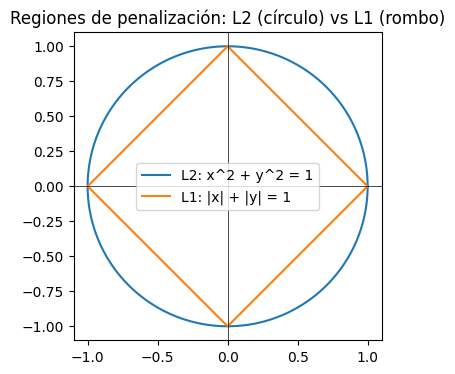

In [6]:
import matplotlib.pyplot as plt

# (No es la figura del artículo, pero ilustra el concepto)
theta = np.linspace(0, 2*np.pi, 200)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

# Rombo L1: |x| + |y| = 1
diamond_x = np.array([0, 1, 0, -1, 0])
diamond_y = np.array([1, 0, -1, 0, 1])

plt.figure(figsize=(4,4))
plt.plot(circle_x, circle_y, label="L2: x^2 + y^2 = 1")
plt.plot(diamond_x, diamond_y, label="L1: |x| + |y| = 1")
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.gca().set_aspect('equal', 'box')
plt.legend()
plt.title("Regiones de penalización: L2 (círculo) vs L1 (rombo)")
plt.show()


## 13. *Sparsity* y selección de variables con L1

El artículo recalca que LASSO no solo es un método de regularización,  
sino también una técnica de **selección de variables**.

Motivo:

- Bajo L1, algunos coeficientes son empujados exactamente a 0.
- Las variables con coeficiente 0 pueden “ser omitidas” del modelo.

Este comportamiento se denomina:

> **inducir sparsity** en el vector de coeficientes.

En problemas con muchas variables, LASSO puede ayudarnos a:

- reducir dimensionalidad,
- mejorar interpretabilidad,
- y centrar el modelo en un subconjunto de *features* relevantes.

Veamos cómo el número de coeficientes exactamente cero cambia con $\lambda$.


In [7]:
alphas_lasso = np.logspace(-3, 0, 10)
zero_counts = []

for a in alphas_lasso:
    l = Lasso(alpha=a, fit_intercept=False, max_iter=10000)
    l.fit(X_mc, y_mc)
    zero_counts.append(np.sum(np.isclose(l.coef_, 0.0)))

for a, z in zip(alphas_lasso, zero_counts):
    print(f"λ={a:7.4f} -> coeficientes exactamente 0: {z}")

λ= 0.0010 -> coeficientes exactamente 0: 1
λ= 0.0022 -> coeficientes exactamente 0: 1
λ= 0.0046 -> coeficientes exactamente 0: 1
λ= 0.0100 -> coeficientes exactamente 0: 1
λ= 0.0215 -> coeficientes exactamente 0: 1
λ= 0.0464 -> coeficientes exactamente 0: 1
λ= 0.1000 -> coeficientes exactamente 0: 1
λ= 0.2154 -> coeficientes exactamente 0: 1
λ= 0.4642 -> coeficientes exactamente 0: 1
λ= 1.0000 -> coeficientes exactamente 0: 2



## 14. Elección de $\lambda$ y el tradeoff sesgo–varianza

En la sección “Specifying Lambda”, el artículo subraya que la elección de $\lambda$ es **crítica**.

- Si $\lambda$ es muy pequeño:
  - Se parece mucho a OLS.
  - Bajo sesgo, pero alta varianza → riesgo de overfitting.
- Si $\lambda$ es muy grande:
  - Los coeficientes se encogen en exceso.
  - Alto sesgo, pero baja varianza → modelo demasiado simple (*underfitting*).

Gráficamente:

- El error de entrenamiento suele **aumentar** con $\lambda$.
- El error de validación/test suele tener una forma de **U** en función de $\lambda$.

Es decir, $\lambda$ controla el **bias–variance tradeoff**.

Veamos este efecto con Ridge en nuestro dataset con multicolinealidad.


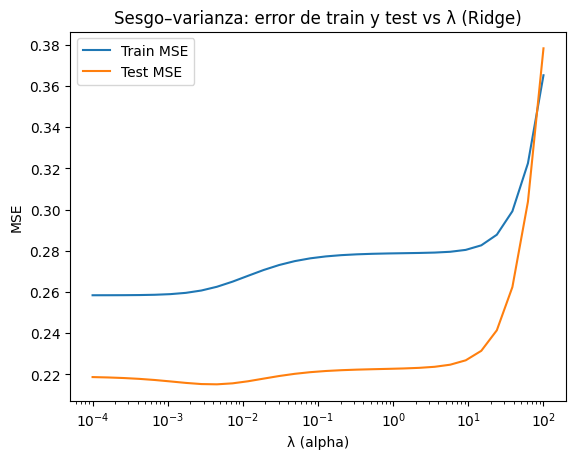

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_mc, y_mc, test_size=0.3, random_state=0)

alphas_grid = np.logspace(-4, 2, 30)
mse_train = []
mse_test = []

for a in alphas_grid:
    r = Ridge(alpha=a, fit_intercept=False)
    r.fit(X_train, y_train)
    mse_train.append(mean_squared_error(y_train, r.predict(X_train)))
    mse_test.append(mean_squared_error(y_test, r.predict(X_test)))

plt.figure()
plt.semilogx(alphas_grid, mse_train, label="Train MSE")
plt.semilogx(alphas_grid, mse_test, label="Test MSE")
plt.xlabel("λ (alpha)")
plt.ylabel("MSE")
plt.legend()
plt.title("Sesgo–varianza: error de train y test vs λ (Ridge)")
plt.show()


## 15. Validación cruzada para seleccionar $\lambda$

En la práctica, como comenta el artículo, usamos **validación cruzada** para elegir $\lambda$:

1. Definimos una rejilla de valores candidatos $\{\lambda_1, \dots, \lambda_K\}$.
2. Para cada $\lambda_k$ entrenamos el modelo usando *k-fold* cross-validation.
3. Calculamos el error medio de validación.
4. Elegimos el valor de $\lambda$ que equilibra bien el error y la complejidad (a menudo, el que minimiza el error de validación).

En scikit-learn, esto se puede hacer con `RidgeCV`, `LassoCV`, etc.

Ejemplo:


In [9]:
from sklearn.linear_model import RidgeCV

alphas_cv = np.logspace(-4, 2, 20)
ridge_cv = RidgeCV(alphas=alphas_cv, fit_intercept=False, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_mc, y_mc)

print("Mejor λ según CV:", ridge_cv.alpha_)
print("Coeficientes Ridge con mejor λ:", ridge_cv.coef_)

Mejor λ según CV: 0.00042813323987193956
Coeficientes Ridge con mejor λ: [ 13.82206437 -12.76509115]



## 16. Regularización en Deep Learning: penalización L2 sobre matrices de pesos

En una red neuronal, los parámetros ya no son solo un vector $\beta$, sino muchas matrices de pesos $W^{(1)}, W^{(2)}, \dots$.

Podemos definir una penalización L2 sobre todos los pesos:

$$
\Omega(W) = \sum_{\ell} \sum_{i,j} \bigl(W^{(\ell)}_{ij}\bigr)^2.
$$

La función de pérdida total toma la forma:

$$
L_{\text{total}} = L_{\text{datos}} + \lambda \,\Omega(W),
$$

donde:

- $L_{\text{datos}}$ es el *data loss* (por ejemplo, entropía cruzada para clasificación).
- $\lambda \,\Omega(W)$ es el término de regularización L2 (similar a Ridge, pero aplicado a la red).

En muchas librerías (PyTorch, TensorFlow, etc.), esto se implementa como **weight decay**.

Ejemplo esquemático (no se ejecuta aquí, solo lectura):


In [10]:
code_pytorch = r"""
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)  # weight_decay = λ

for epoch in range(100):
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    loss = criterion(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
"""

print(code_pytorch)


import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)  # weight_decay = λ

for epoch in range(100):
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    loss = criterion(y_pred, y_tensor)
    loss.backward()
    optimizer.step()




## 17. Otras formas de regularización en Deep Learning

Otras formas de regularización o “comportamiento similar” en redes profundas:

1. **L1 y L2 regularización** sobre los pesos  
   - Igual que en regresión, se puede aplicar sobre las matrices de pesos.

2. **Dropout**  
   - Durante el entrenamiento, se “apagan” neuronas aleatoriamente con probabilidad $p$.
   - Obliga a la red a no depender en exceso de ninguna neurona.

3. **Batch / Layer / Spatial Normalization**  
   - Normalizan activaciones intermedias, reduciendo cambios drásticos en la distribución interna (*internal covariate shift*).
   - Esto estabiliza y regulariza el entrenamiento.

4. **Early stopping**  
   - Se monitoriza el error de validación a lo largo de las épocas.
   - Se detiene el entrenamiento cuando el error de validación deja de mejorar (o empeora).

Todas estas técnicas, aunque no siempre se expresen como un término explícito $\lambda \,\Omega(W)$,  
**limitan la capacidad efectiva** del modelo y reducen el overfitting.



## 18. Síntesis conceptual: regularización como principio unificador

Recapitulando lo visto (y lo que enfatiza el artículo):

1. **OLS** proporciona una solución cerrada para regresión lineal, pero depende fuertemente de que $X^{\top} X$ sea bien condicionada e invertible.
2. **Regularización L2 (Ridge / Tikhonov)**:
   - Añade $\lambda \lVert \beta \rVert_2^2$ al *loss*.
   - Conduce a una solución $\hat{\beta}_{\text{ridge}} = (X^{\top} X + \lambda I)^{-1} X^{\top} y$.
   - Arregla problemas de no unicidad y mala condición, reduciendo la sensibilidad al ruido.
3. **Regularización L1 (LASSO)**:
   - Añade $\lambda \lVert \beta \rVert_1$ al *loss*.
   - Hace que algunos coeficientes sean exactamente 0 (*sparsity*).
   - Permite usar el método como herramienta de selección de variables.
4. **El hiperparámetro $\lambda$**:
   - Controla explícitamente el tradeoff entre sesgo y varianza.
   - Debe elegirse con cuidado, por ejemplo mediante validación cruzada.
5. **Deep Learning**:
   - Reutiliza estas ideas (L2 sobre pesos) y las complementa con dropout, normalización y early stopping.

Regularización, vista así, es un **principio general** para:

- hacer los problemas **bien planteados** (numéricamente estables),
- controlar la **complejidad** del modelo,
- y mejorar la **generalización**.



## 19. Ejemplo completo en Python: OLS vs Ridge vs LASSO

Cerramos con un ejemplo integrado donde:

- Generamos un dataset con $p = 20$ *features*, algunas correlacionadas.
- Solo unas pocas variables son realmente relevantes.
- Comparamos:
  - OLS (sin regularizar),
  - Ridge (L2),
  - LASSO (L1).

Miramos:

- El error en test (MSE),
- La estructura de los coeficientes estimados.


OLS          | MSE test =   1.361
Ridge (λ=1)  | MSE test =   1.314
LASSO (λ=0.1) | MSE test =   1.336


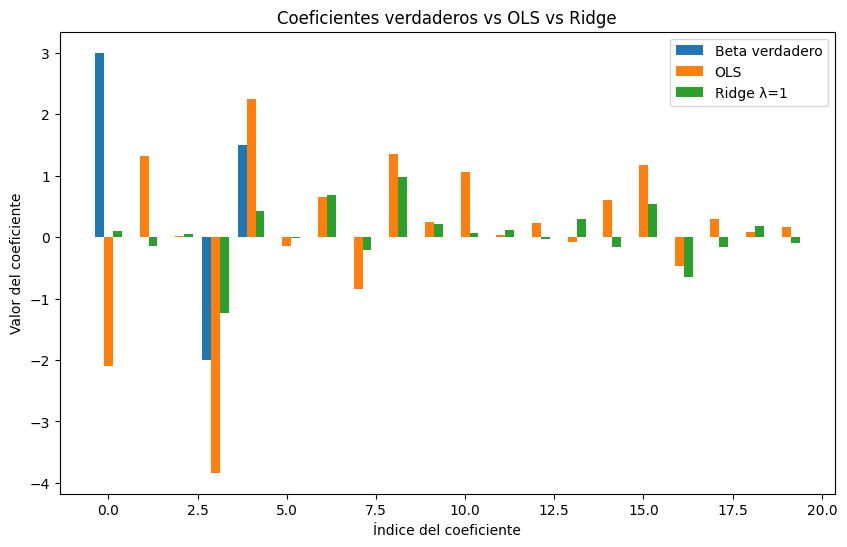

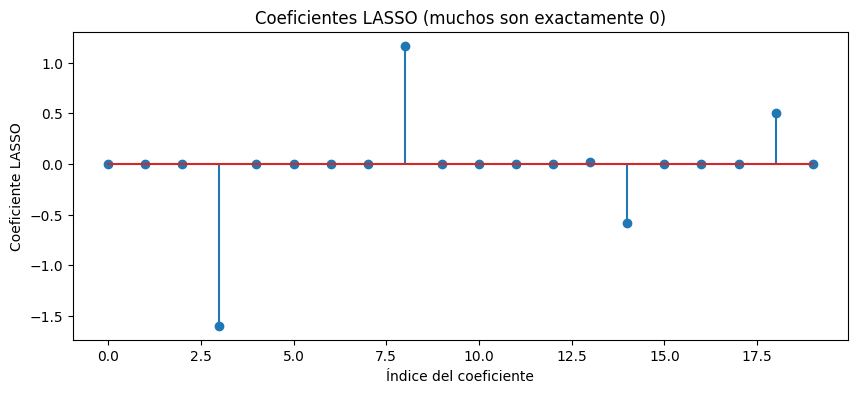

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
n, p = 200, 20

# Matriz base de 5 features
X_base = rng.normal(size=(n, 5))
# Generamos el resto como combinaciones lineales + ruido pequeño
noise_extra = rng.normal(scale=0.1, size=(n, p-5))
X_rest = X_base @ rng.normal(size=(5, p-5)) + noise_extra
X_big = np.hstack([X_base, X_rest])

# Coeficientes verdaderos esparsos
beta_true = np.zeros(p)
beta_true[:5] = [3.0, 0.0, 0.0, -2.0, 1.5]  # solo 3 relevantes

y_big = X_big @ beta_true + rng.normal(scale=1.0, size=n)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_big, y_big, test_size=0.3, random_state=0)

models = {
    "OLS": LinearRegression(fit_intercept=False),
    "Ridge (λ=1)": Ridge(alpha=1.0, fit_intercept=False),
    "LASSO (λ=0.1)": Lasso(alpha=0.1, fit_intercept=False, max_iter=10000)
}

results = {}

for name, model in models.items():
    model.fit(X_train_b, y_train_b)
    y_pred = model.predict(X_test_b)
    mse = mean_squared_error(y_test_b, y_pred)
    results[name] = (mse, model.coef_)
    print(f"{name:12s} | MSE test = {mse:7.3f}")

# Graficar coeficientes verdaderos vs OLS vs Ridge
plt.figure(figsize=(10, 6))
idx = np.arange(p)
width = 0.25

plt.bar(idx - width, beta_true, width, label="Beta verdadero")
plt.bar(idx, results["OLS"][1], width, label="OLS")
plt.bar(idx + width, results["Ridge (λ=1)"][1], width, label="Ridge λ=1")

plt.xlabel("Índice del coeficiente")
plt.ylabel("Valor del coeficiente")
plt.title("Coeficientes verdaderos vs OLS vs Ridge")
plt.legend()
plt.show()

# Coeficientes LASSO
plt.figure(figsize=(10, 4))
plt.stem(results["LASSO (λ=0.1)"][1])
plt.xlabel("Índice del coeficiente")
plt.ylabel("Coeficiente LASSO")
plt.title("Coeficientes LASSO (muchos son exactamente 0)")
plt.show()


## 20. Comentarios finales: qué deberías llevarte de este notebook

A partir de la lectura del artículo y de este notebook ampliado, deberías:

- Entender **por qué** agregar un término de regularización al *loss* tiene sentido más allá del mantra “reduce el overfitting”.
- Saber que L2 (Ridge / Tikhonov):
  - mejora el condicionamiento de $$X^{\top} X$$,
  - conduce a soluciones únicas y estables,
  - encoge todos los coeficientes.
- Saber que L1 (LASSO):
  - comparte el espíritu de penalizar coeficientes grandes,
  - pero además induce *sparsity* (coeficientes exactamente cero),
  - lo que lo vuelve útil para selección de variables.
- Tener clara la importancia del hiperparámetro $$\lambda$$ y cómo usar validación cruzada para elegirlo.
- Reconocer que estas ideas se trasladan casi directamente a **Deep Learning**, donde la regularización es crucial para entrenar redes que generalizan bien.

Si tienes dudas o curiosidad sobre alguna parte (por ejemplo, detalles de la derivación matricial, la interpretación Bayesiana, o cómo se implementa exactamente `weight_decay` en un framework específico), es un excelente punto de partida para profundizar en clase o en lecturas adicionales.
